In [ ]:
# !pip install yfinance

In [ ]:
# !pip install keras-tuner

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import hashlib
import json
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import keras_tuner as kt

2025-12-02 19:06:16.272719: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 19:06:16.299673: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 19:06:16.943927: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100.0

print("TensorFlow:", tf.__version__)
print("Using CUDA GPU:", tf.config.list_physical_devices('GPU'))

TensorFlow: 2.20.0
Using CUDA GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
end_date = datetime.now()
start_date = end_date - timedelta(days=60)
end_date = "2025-11-24"
horizon = "30m"

print("Start date:", start_date)
print("End date:", end_date)

Start date: 2025-10-03 19:06:18.528239
End date: 2025-11-24


In [4]:
gold = yf.download("GC=F", start = start_date, end = end_date, interval = horizon, auto_adjust = False)
silver = yf.download("SI=F", start = start_date, end = end_date, interval = horizon,auto_adjust = False)
cad = yf.download("CADUSD=X", start = start_date, end = end_date, interval = horizon, auto_adjust = False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
gold.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1606 entries, 2025-10-06 04:00:00+00:00 to 2025-11-24 04:30:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, GC=F)  1606 non-null   float64
 1   (Close, GC=F)      1606 non-null   float64
 2   (High, GC=F)       1606 non-null   float64
 3   (Low, GC=F)        1606 non-null   float64
 4   (Open, GC=F)       1606 non-null   float64
 5   (Volume, GC=F)     1606 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 87.8 KB


In [6]:
silver.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1606 entries, 2025-10-06 04:00:00+00:00 to 2025-11-24 04:30:00+00:00
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Adj Close, SI=F)  1606 non-null   float64
 1   (Close, SI=F)      1606 non-null   float64
 2   (High, SI=F)       1606 non-null   float64
 3   (Low, SI=F)        1606 non-null   float64
 4   (Open, SI=F)       1606 non-null   float64
 5   (Volume, SI=F)     1606 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 87.8 KB


In [7]:
cad.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1669 entries, 2025-10-03 18:00:00+00:00 to 2025-11-21 22:00:00+00:00
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, CADUSD=X)  1669 non-null   float64
 1   (Close, CADUSD=X)      1669 non-null   float64
 2   (High, CADUSD=X)       1669 non-null   float64
 3   (Low, CADUSD=X)        1669 non-null   float64
 4   (Open, CADUSD=X)       1669 non-null   float64
 5   (Volume, CADUSD=X)     1669 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 91.3 KB


In [8]:
def asset_heatmap(df, asset_name):
    plt.figure(figsize=(7, 5))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
    plt.title(f"{asset_name} Feature Correlation Heatmap")
    plt.show()

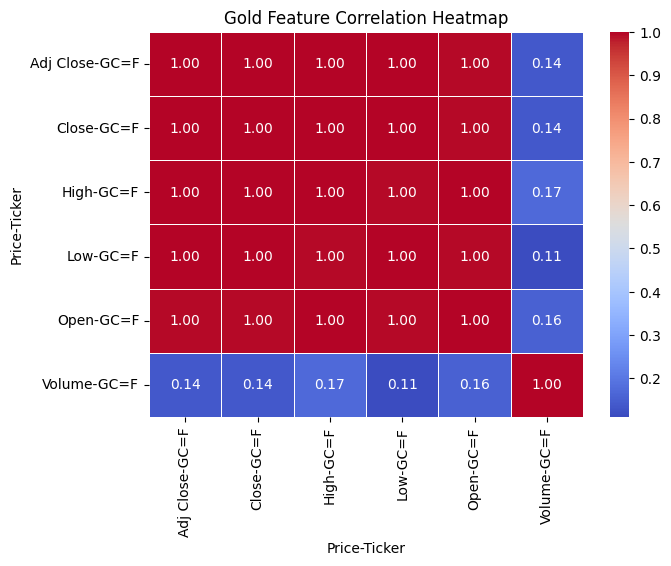

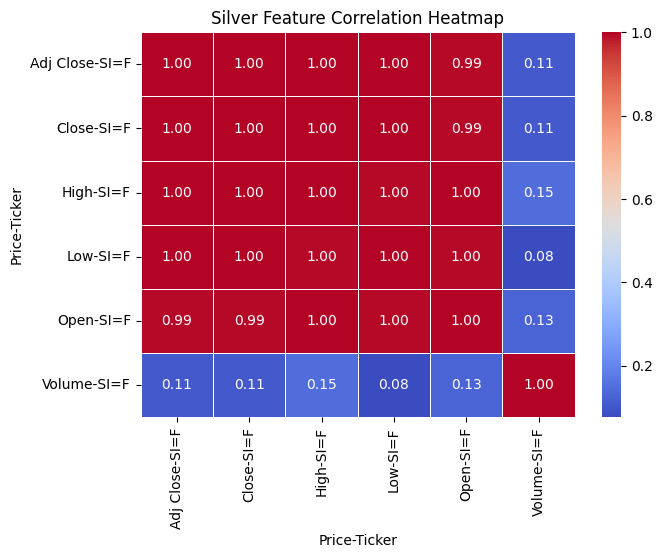

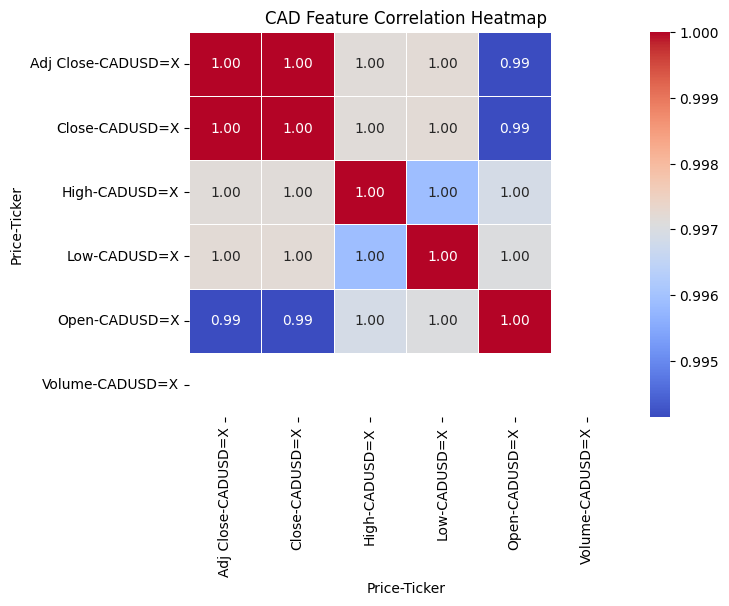

In [9]:
asset_heatmap(gold, "Gold")
asset_heatmap(silver, "Silver")
asset_heatmap(cad, "CAD")

In [10]:
gold = gold[["Close"]].rename(columns={"Close": "Gold"})
silver = silver[["Close"]].rename(columns={"Close": "Silver"})
cad = cad[["Close"]].rename(columns={"Close": "CAD"})

In [11]:
all_prices = gold.join([silver, cad], how="outer")
all_prices.to_csv("prices_with_null.csv")

In [12]:
all_prices = all_prices.ffill().bfill() # forward-fill + backward-fill to deal with missing values
all_prices.to_csv("prices.csv")

In [13]:
all_prices.head()

Price,Gold,Silver,CAD
Ticker,GC=F,SI=F,CADUSD=X
Datetime,,,
2025-10-03 18:00:00+00:00,3958.5,48.395,0.716676
2025-10-03 18:30:00+00:00,3958.5,48.395,0.716717
2025-10-03 19:00:00+00:00,3958.5,48.395,0.716851
2025-10-03 19:30:00+00:00,3958.5,48.395,0.716728
2025-10-03 20:00:00+00:00,3958.5,48.395,0.716753


In [14]:
all_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1692 entries, 2025-10-03 18:00:00+00:00 to 2025-11-24 04:30:00+00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Gold, GC=F)     1692 non-null   float64
 1   (Silver, SI=F)   1692 non-null   float64
 2   (CAD, CADUSD=X)  1692 non-null   float64
dtypes: float64(3)
memory usage: 52.9 KB


In [15]:
all_prices.describe()

Price,Gold,Silver,CAD
Ticker,GC=F,SI=F,CADUSD=X
count,1692.000000,1692.000000,1692.000000
mean,4087.451535,49.435288,0.713282
std,101.127076,1.796883,0.002401
min,3912.000000,45.665001,0.707269
25%,4008.900024,48.068749,0.711981
50%,4067.500000,48.712500,0.713348
75%,4138.100098,50.744999,0.714726
max,4394.299805,54.299999,0.719746


## hyperparameter tuning

In [16]:
import tensorflow as tf

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def mape(y_true, y_pred):
    return tf.reduce_mean(tf.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

In [17]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(all_prices)

def create_sequences(data, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i : i + timesteps])
        y.append(data[i + timesteps])
    return np.array(X), np.array(y)

In [18]:
max_window = 60

X_all, y_all = create_sequences(scaled, max_window)

split = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split], X_all[split:]
y_train, y_test = y_all[:split], y_all[split:]

In [19]:
# hyperparameter tuning

def build_model(hp):
    model = Sequential()
    
    window = hp.Int("window", min_value=10, max_value=60, step=10)
    
    rnn_type = hp.Choice("rnn_type", ["LSTM", "GRU"])
    rnn_layer = LSTM if rnn_type == "LSTM" else GRU

    # first layer
    model.add(
        rnn_layer(
            units=hp.Int("units_1", min_value=16, max_value=128, step=16),
            return_sequences=True,
            input_shape=(window, 3),
            kernel_regularizer=l2(hp.Choice("l2_reg", [1e-6, 1e-5, 1e-4])),
        )
    )
    model.add(Dropout(hp.Float("dropout_1", 0.1, 0.5, step=0.1)))

    # second layer
    model.add(
        rnn_layer(
            units=hp.Int("units_2", min_value=8, max_value=64, step=8),
            return_sequences=False,
            kernel_regularizer=l2(hp.Choice("l2_reg2", [1e-6, 1e-5, 1e-4])),
        )
    )
    model.add(Dropout(hp.Float("dropout_2", 0.1, 0.5, step=0.1)))

    # dense layer
    model.add(Dense(hp.Int("dense_units", 8, 64, step=8), activation="relu"))

    # output
    model.add(Dense(3))

    # learning rate
    lr = hp.Choice("learning_rate", [1e-2, 5e-3, 1e-3, 5e-4, 1e-4])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mse",
        metrics=[rmse, mae, mape]
    )

    return model

In [20]:
tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective("val_rmse", direction="min"),
    max_trials=30,
    executions_per_trial=1,
    directory="tuning_results",
    project_name="model-30m",
)

Reloading Tuner from tuning_results/model-30m/tuner0.json


In [21]:
earlystop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

tuner.search(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[earlystop],
    verbose=1
)

In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
best_hp.values

best_model = tuner.get_best_models(1)[0]

print(best_hp.values)
best_model.summary()

Best Hyperparameters:


I0000 00:00:1764695203.253891  107360 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1764695203.264121  107360 cuda_executor.cc:508] failed to allocate 14.75MiB (15466496 bytes) from device: RESOURCE_EXHAUSTED: : CUDA_ERROR_OUT_OF_MEMORY: out of memory
/home/rita/anaconda3/envs/Python3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

y_pred = best_model.predict(X_test)

y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

rmse_val = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae_val  = mean_absolute_error(y_test_inv, y_pred_inv)
mape_val = mean_absolute_percentage_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse_val)
print("MAE :", mae_val)
print("MAPE:", mape_val)

model = best_model

In [ ]:
y_pred = model.predict(X_test)

# inverse scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

In [ ]:
baseline = scaler.inverse_transform(X_test[:, -1, :]) # last real point

In [ ]:
def plot_asset(i, asset_name):
    plt.figure(figsize=(12,5))
    plt.plot(y_test_inv[:, i], label="Actual", color="blue")
    plt.plot(y_pred_inv[:, i], label="Predicted", color="orange")
    plt.plot(baseline[:, i], label="Baseline", color="magenta")
    plt.title(f"{asset_name} - LSTM 1d")
    plt.xlabel("Time")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_asset(0, "Gold")
plot_asset(1, "Silver")
plot_asset(2, "CAD")

In [ ]:
def mae(y, p): return np.mean(np.abs(y-p))
def rmse(y, p): return np.sqrt(np.mean((y-p)**2))
def mape(y, p): return np.mean(np.abs((y-p)/y))*100

assets = ["Gold","Silver","CAD"]
for i in range(3):
    print(assets[i])
    print(" MAE :", mae(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" RMSE:", rmse(y_test_inv[:,i], y_pred_inv[:,i]))
    print(" MAPE:", mape(y_test_inv[:,i], y_pred_inv[:,i]))
    print()

In [ ]:
predict_window = 70

def parse_range(user_input): #format: DD-MM-YYYY; DD-MM-YYYY
   # Example: 10-12-2025; 14-12-2025
    if ";" not in user_input:
        raise ValueError("Invalid format. Use: DD-MM-YYYY; DD-MM-YYYY")

    parts = user_input.split(";")
    if len(parts) != 2:
        raise ValueError("Invalid format. Use: DD-MM-YYYY; DD-MM-YYYY")

    start_str = parts[0].strip()
    end_str   = parts[1].strip()

    try:
        start = datetime.strptime(start_str, "%d-%m-%Y")
        end   = datetime.strptime(end_str, "%d-%m-%Y")
    except:
        raise ValueError("Invalid date. Use exactly this format: DD-MM-YYYY; DD-MM-YYYY")

    return start, end

def user_date():
    while True:
        user_input = input("Enter date range exactly in this format inside the parenthesis, with the start date first (DD-MM-YYYY; DD-MM-YYYY): ")

        try:
            start, end = parse_range(user_input)
            return user_input
        except Exception as e:
            print(f"\nError: {str(e)}\nPlease try again.\n")


def predict_range(date_string, interval="30m"):
    start, end = parse_range(date_string)

    # downloading data to be able to compare with the actual value
    gold = yf.download("GC=F", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "Gold"})
    silver = yf.download("SI=F", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "Silver"})
    cad = yf.download("CADUSD=X", start=start, end=end, interval=interval, auto_adjust = False)[["Close"]].rename(columns={"Close": "CAD"})
    
    
    data = gold.join([silver, cad], how="outer").dropna()

    if data.shape[0] == 0:
        raise ValueError(
            f"No Yahoo Finance data found between {start.date()} and {end.date()} "
            f"for interval='{interval}'. "
            "Try an earlier date range that already has price history."
        )

    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    X_seq = []
    last_seq = scaled[-predict_window:]
    window = np.vstack([scaled[-predict_window:], scaled_data])

    for i in range(len(data)):
        seq = window[i:i+predict_window]
        if seq.shape[0] == predict_window:
            X_seq.append(seq)

    X_seq = np.array(X_seq)

    preds = model.predict(X_seq)
    preds_inv = scaler.inverse_transform(preds)

    data["Gold_pred"], data["Silver_pred"], data["CAD_pred"] = (
        preds_inv[:, 0], preds_inv[:, 1], preds_inv[:, 2]
    )

    return data


def plot_results(df):
    assets = ["Gold", "Silver", "CAD"]
    for asset in assets:
        actual = df[asset].values
        predicted = df[f"{asset}_pred"].values
        
        # baseline: next price = current actual
        baseline = np.roll(actual, 1)
        baseline[0] = actual[0]  

        plt.figure(figsize=(12,5))
        plt.plot(df.index, actual, label=f"{asset} Actual", color="blue")
        plt.plot(df.index, predicted, label=f"{asset} Predicted", color="orange")
        plt.plot(df.index, baseline, label=f"{asset} Baseline", color="magenta")
        
        plt.title(f"{asset} - Actual vs Predicted vs Baseline")
        plt.xlabel("Time and Date")
        plt.ylabel("Price (USD)")
        plt.legend()
        plt.grid(True)
        plt.show()


# 20-11-2025; 28-11-2025
user_range = user_date()
user_df = predict_range(user_range, interval="30m")
plot_results(user_df)

In [ ]:
user_df.head()

In [ ]:
# 29-11-2025; 02-12-2025
user_range = user_date()
user_df = predict_range(user_range, interval="30m")
user_df.head()
plot_results(user_df)

In [ ]:
user_df.head()

In [ ]:
user_df.to_csv("predictions.csv")